**MSM analysis on colab**

In [ ]:
!nvidia-smi

Sat Mar 27 05:38:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------



**Import the required libraries**



In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm


!pip install pyemma
!pip install threadpoolctl

import pyemma

     |████████████████████████████████| 1.6MB 6.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/af/da/271e93bb98bc93ccac17bc1f31f814be4f9e7024ac19bf31af892a462030/mdtraj-1.9.5-cp37-cp37m-manylinux1_x86_64.whl
     |████████████████████████████████| 81kB 7.0MB/s 
Processing /root/.cache/pip/wheels/35/53/59/f40630becd10a799470093cd5209fcc4351da6a15650eadc3d/deeptime-0.2.6-cp37-cp37m-linux_x86_64.whl
     |████████████████████████████████| 604kB 16.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 327kB 25.6MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
  Created wheel for pyemma: filename=pyEMMA-2.5.9-cp37-cp37m-linux_x86_64.whl size=2497971 sha256=702a33d3af324d1812728c4eef2f2fd3c5270083d059308e15d227e8771b0ab4
  St

**Mount the google drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load the encoded dataset**

In [3]:
latent = torch.load('/content/drive/MyDrive/DNN_TAE/latent_dnn_tae.pt',map_location='cpu')
latent = np.array(latent.detach())

In [ ]:
#cluster_kmeans = pickle.load(open('/content/drive/MyDrive/Autoencoding/cluster_kmeans_ae.pkl','rb'))

In [ ]:
#pickle.dump(cluster_kmeans,open('cluster_1000.pkl','wb'))

In [ ]:
np.shape(latent)

(3226386, 2)

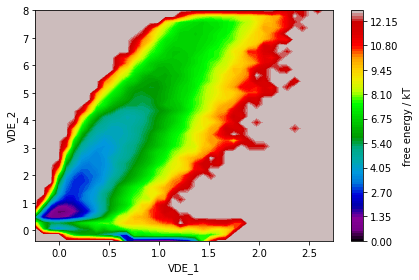

In [4]:
fig, ax, misc =pyemma.plots.plot_free_energy(*latent.T,nbins=40,
                                             legacy=False,avoid_zero_count=True)
ax.set_xlabel('VDE_1')
ax.set_ylabel('VDE_2')
fig.tight_layout()
plt.savefig('VDE_fes.png' ,dpi=300)

In [ ]:
#!mv VDE_fes.png /content/drive/MyDrive/VDE_with_scaling/scale_0.1/

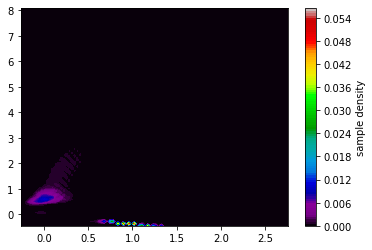

In [5]:
fig,ax,misc = pyemma.plots.plot_density(*latent.T,avoid_zero_count=True,cmap='nipy_spectral')
fig.savefig('density_plot.png',dpi = 300)

In [6]:
%%time
cluster_kmeans = pyemma.coordinates.cluster_kmeans(latent, max_iter=1500, k=1500)

CPU times: user 2h 11min 49s, sys: 9.86 s, total: 2h 11min 58s
Wall time: 34min 47s


In [12]:
import pickle

pickle.dump(cluster_kmeans,open('cluster_kmeans.pkl','wb'))

In [13]:
cluster_kmeans.dtrajs

[array([ 80, 535, 533, ..., 476, 871, 674], dtype=int32)]

In [14]:
lags=[2,10,20,40,60,80,110, 140, 170, 200, 240]
its =pyemma.msm.its(cluster_kmeans.dtrajs,lags=lags, nits =10)

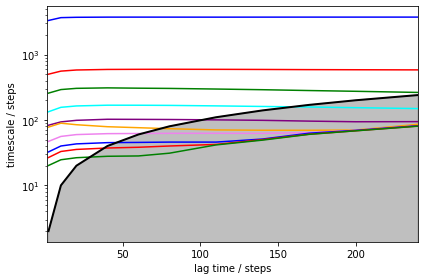

In [15]:
fig = pyemma.plots.plot_implied_timescales(its,nits=10, ylog=True)
#plt.xlim(2,100)
plt.tight_layout()
plt.savefig('its_tae_1.png', dpi =300)

In [16]:
msm = pyemma.msm.estimate_markov_model(cluster_kmeans.dtrajs, lag=50)

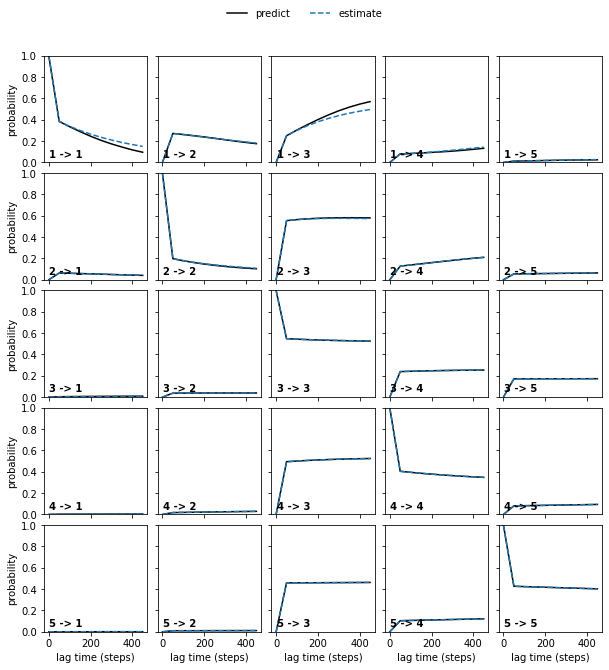

In [17]:
fig=pyemma.plots.plot_cktest(msm.cktest(5))

plt.savefig('cktest_6.png', dpi = 300)

In [18]:
print('fraction of states used = {:f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:f}'.format(msm.active_count_fraction))

fraction of states used = 0.997333
fraction of counts used = 1.000000


In [19]:
print(msm.stationary_distribution)
print('sum of weights = {:f}'.format(msm.pi.sum()))

[0.0009438  0.01173481 0.00041498 ... 0.00036873 0.00038017 0.00092665]
sum of weights = 1.000000


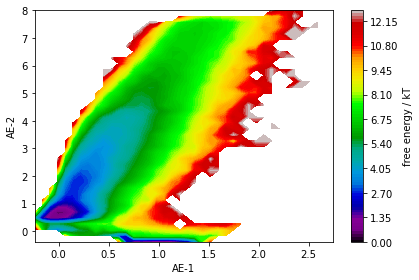

In [20]:
fig, ax, misc = pyemma.plots.plot_free_energy(
    *latent.T,nbins=40,
    weights=np.concatenate(msm.trajectory_weights()),
    legacy=False)
ax.set_xlabel('AE-1')
ax.set_ylabel('AE-2')
#ax.set_xlim(-4, 4)
#ax.set_ylim(-4, 4)
#ax.set_aspect('equal')
fig.tight_layout()
plt.savefig('reweighted_fes_ae.png',dpi =300)

In [21]:
for i, s in enumerate(msm.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, msm.pi[s].sum()))

π_1 = 0.006597
π_2 = 0.011348
π_3 = 0.674799
π_4 = 0.307256
π_5 = 0.000000


In [22]:
nstates=5
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / steps:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

ValueError: ignored

In [46]:
np.shape(msm.metastable_sets)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(5,)

In [23]:
msm.dtrajs_active

[array([ 80, 535, 533, ..., 476, 869, 673])]

In [24]:
metastable_traj = msm.metastable_assignments[tuple(msm.dtrajs_active)]
highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster_kmeans.clustercenters[msm.active_set[highest_membership]]

In [48]:
np.shape(msm.stationary_distribution)

(1496,)

In [25]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

ValueError: ignored

KeyboardInterrupt: ignored

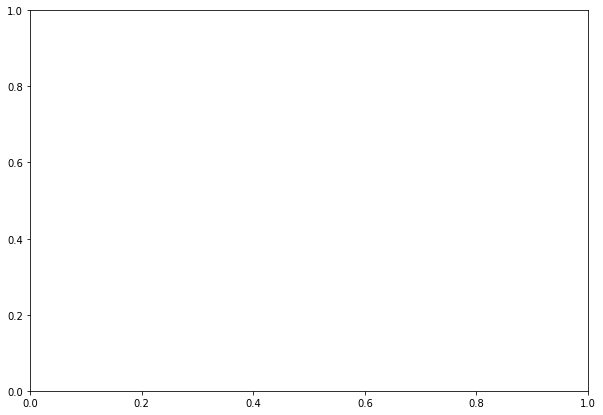

In [26]:
fig, ax = plt.subplots(figsize=(10, 7))
_, _, misc = pyemma.plots.plot_state_map(
    *latent.T, metastable_traj,nbins=40, ax=ax, zorder=-1)
misc['cbar'].set_ticklabels(range(0, nstates+1))  # set state numbers 1 ... nstates

# pyemma.plots.plot_network(
#      inverse_mfpt,
# # #    pos=coarse_state_centers,
#      pos = np.array([[0.95,0.4],
#                      [0.85, 0.70],
#                      [0.6 , 0.9],
#                     [0.2 , 0.6]]),
# #     xpos=np.array([0.8791888,0.7490787,0.80000,0.50973363]),
#      state_scale=0.4,
# #     #arrow_scale=1.0,
#      arrow_curvature=0.5,
# #     figpadding=None,
#      arrow_label_format='%.1f ps',
#      arrow_labels=mfpt,
#      size=12,
#      show_frame=True,
#      ax=ax)

#ax.set_xlabel('$\Phi$')
#ax.set_ylabel('$\Psi$')
#ax.set_xlim(0, 1)
#ax.set_ylim(0, 1)
fig.tight_layout()
plt.savefig('Ae_4_state_1000cls.png',dpi=300)

In [31]:
A = np.concatenate(msm.trajectory_weights())
A.shape

(4022018,)

In [34]:
weighted_latent = np.empty_like(latent)

In [36]:
weighted_latent[:,0] = latent[:,0]*np.concatenate(msm.trajectory_weights())
weighted_latent[:,1] = latent[:,1]*np.concatenate(msm.trajectory_weights())

In [37]:
weighted_latent.shape

(4022018, 2)

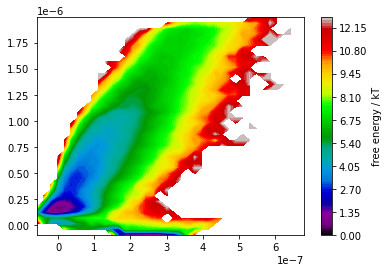

In [38]:
fig, ax, misc = pyemma.plots.plot_free_energy(
    *weighted_latent.T,nbins=40,
    legacy=False)

In [42]:
pickle.dump(msm,open('msm_lag_50.pkl','wb'))

In [39]:
np.save('weighted_latent.npy',weighted_latent)

In [43]:
!mv msm_lag_50.pkl /content/drive/MyDrive/DNN_TAE

In [41]:
!mv cluster_kmeans.pkl /content/drive/MyDrive/DNN_TAE

In [ ]:
unscaled = np.load('/content/drive/MyDrive/Autoencoding/Unscaled_data_sorted.npy')

In [ ]:
unscaled = unscaled[np.where(unscaled[:,0] <1.8)]

In [ ]:
np.max(unscaled,axis=0)

array([ 1.799, 42.   ])

In [ ]:
state0=unscaled[metastable_traj==0]
state1=unscaled[metastable_traj==1]
state2=unscaled[metastable_traj==2]
state3=unscaled[metastable_traj==3]
state4=unscaled[metastable_traj==4]

In [ ]:
print(np.mean(state0,axis=0))
print(np.mean(state1,axis=0))
print(np.mean(state2,axis=0))
print(np.mean(state3,axis=0))
print(np.mean(state4,axis=0))

[ 1.37088656 20.49155739]
[ 1.27516016 18.09560327]
[ 1.31423173 19.20221235]
[ 1.29246379 18.60268075]
[ 1.05817634 11.93269457]


In [ ]:
pickle.dump(cluster_kmeans,open('cluster_kmeans_1500_tae.pkl','wb'))